Libraries imports:

In [1]:
import sys
print(sys.executable)
!pip install -q skorch
!python -m pip install --upgrade pip
!python -m pip install torch torchvision torchaudio
!python -m pip install matplotlib
!python -m pip install numpy
!python -m pip install scikit-learn
!python -m pip install skorch
!python -m pip install seaborn
import torch
print(torch.__version__)

c:\Users\Liory\AppData\Local\Programs\Python\Python311\python.exe


'pip' is not recognized as an internal or external command,
operable program or batch file.


2.9.1+cpu


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from skorch.helper import SliceDataset
from sklearn.model_selection import train_test_split


1+2. Data Preparation:
I used the Fashion-MNIST dataset, a widely-used dataset of 70,000 28x28 grayscale image from 10 classes. The dataset is divided into 60,000 training images and 10,000 test images.

In [3]:
# transforms: ToTensor + Normalize 
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## give to address a name:
root_dir = r"C:\Users\Liory\Downloads\Fashion-MNIST_Dataset"

## Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root=root_dir, train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root=root_dir ,train=False ,download=True ,transform=test_transform)

## Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# checking if this correct 
img, label = train_dataset[0]
print("img shape:", img.shape) 
torch.Size([1, 28, 28])
print("label:", label)
print("train size:", len(train_dataset), "test size:", len(test_dataset))


img shape: torch.Size([1, 28, 28])
label: 9
train size: 60000 test size: 10000


In [ ]:
def imshow(img):
    img = img / 2 + 0.5       
    npimg = img.numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(npimg[0], cmap='gray')  
    plt.axis('off')
    plt.show()

    
    # Get a batch of training images
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Show images in a grid
    imshow(torchvision.utils.make_grid(images))

3. Model Building:

In [5]:
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B,32,14,14]
        x = self.pool(torch.relu(self.conv2(x)))  # [B,64,7,7]
        x = x.view(x.size(0), -1)                 # [B, 64*7*7]
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))               # [B,512]
        x = self.fc2(x)                           # [B,10] logits
        return x


def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())


if __name__ == "__main__":
    model = CNN(dropout=0.3)

    x = torch.randn(4, 1, 28, 28)  # batch=4, grayscale, 28x28
    y = model(x)
    print("Input shape :", x.shape)
    print("Output shape:", y.shape)  

    # Conv1: out=32, in=1, k=3x3 + bias per out channel
    conv1_total = (32 * 1 * 3 * 3) + 32

    # Conv2: out=64, in=32, k=3x3 + bias
    conv2_total = (64 * 32 * 3 * 3) + 64

    # FC1: out=512, in=64*7*7 + bias
    fc1_in = 64 * 7 * 7
    fc1_total = (512 * fc1_in) + 512

    # FC2: out=10, in=512 + bias
    fc2_total = (10 * 512) + 10

    total_manual = conv1_total + conv2_total + fc1_total + fc2_total

    weights = {
        "Conv1 Weights": conv1_total,
        "Conv2 Weights": conv2_total,
        "FC1 Weights": fc1_total,
        "FC2 Weights": fc2_total,
        "Total Weights (manual)": total_manual,
        "Total Params (pytorch)": count_params(model),
    }

    print("\nWeights:", weights)


Input shape : torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])

Weights: {'Conv1 Weights': 320, 'Conv2 Weights': 18496, 'FC1 Weights': 1606144, 'FC2 Weights': 5130, 'Total Weights (manual)': 1630090, 'Total Params (pytorch)': 1630090}


4. Training:

Epoch 1/12, Train Loss: 0.7229, Val Loss: 0.4822
Epoch 3/12, Train Loss: 0.4493, Val Loss: 0.3527
Epoch 5/12, Train Loss: 0.3912, Val Loss: 0.3241
Epoch 7/12, Train Loss: 0.3664, Val Loss: 0.2985
Epoch 9/12, Train Loss: 0.3477, Val Loss: 0.2875
Epoch 11/12, Train Loss: 0.3364, Val Loss: 0.2796


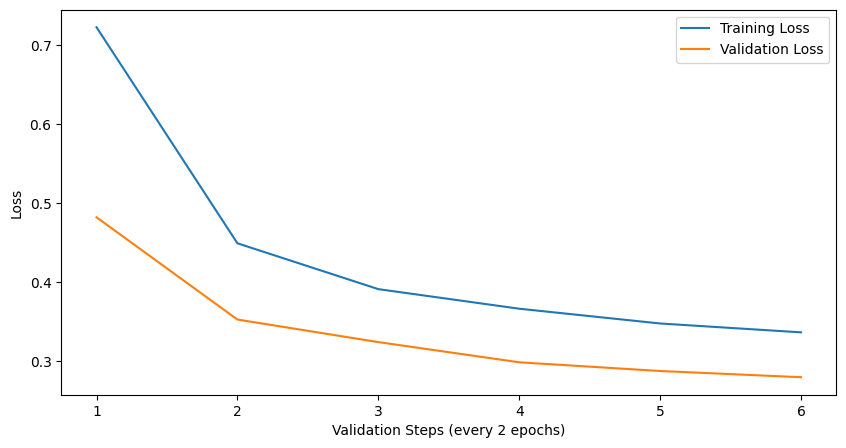

In [ ]:
## ---------- Updated transformations with data augmentation ----------
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),   
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## ---------- Datasets + Loaders ----------
root_dir = r"C:\Users\Liory\Downloads\Fashion-MNIST_Dataset"

train_dataset = datasets.FashionMNIST(root=root_dir, train=True,  download=True, transform=transform_train)
test_dataset  = datasets.FashionMNIST(root=root_dir, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

## ---------- Model ----------
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)   # 28->14->7
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B,32,14,14]
        x = self.pool(torch.relu(self.conv2(x)))  # [B,64,7,7]
        x = x.view(x.size(0), -1)                 # [B,64*7*7]
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))               # [B,512]
        x = self.fc2(x)                           # [B,10] logits
        return x

model = CNN()

## ---------- Loss + Optimizer ----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## ---------- Training loop ----------
num_epochs = 12
train_losses = []
val_losses = []

for epoch in range(num_epochs): 
    running_loss = 0.0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()        
        outputs = model(inputs)       
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()             
        running_loss += loss.item()

    # Validation phase 
    if epoch % 2 == 0:
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

## ---------- Visualization Plot ----------
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Validation Steps (every 2 epochs)')
plt.ylabel('Loss')
plt.legend()
plt.show()

5. Evaluation:

In [30]:
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():       
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 90.09%


6. Visualization:

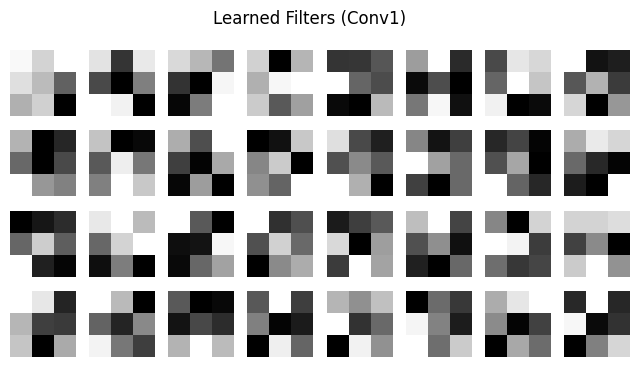

In [ ]:
def visualize_filters(layer):
    filters = layer.weight.data.clone() 

    # נרמול להצגה
    filters = filters - filters.min()
    filters = filters / filters.max()

    filter_num = filters.shape[0]
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))

    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i, 0], cmap='gray')
        axs[row, col].axis('off')

    plt.suptitle("Learned Filters (Conv1)")
    plt.show()

model = CNN()
visualize_filters(model.conv1)


In [35]:
def visualize_intermediate_layers(image, model):
    model.eval()

    activations = []

    x = image.unsqueeze(0)

    # ----- Conv1 -----
    x = model.conv1(x)
    x = torch.relu(x)
    activations.append(x)   
    x = model.pool(x)

    # ----- Conv2 -----
    x = model.conv2(x)
    x = torch.relu(x)
    activations.append(x)  
    x = model.pool(x)

    # ----- Visualization -----
    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0)  
        num_maps = feature_maps.shape[0]

        n_columns = 8
        n_rows = num_maps // n_columns + (num_maps % n_columns > 0)

        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Feature Maps after Conv Layer {idx + 1}')

        for i in range(num_maps):
            row = i // n_columns
            col = i % n_columns
            axs[row, col].imshow(feature_maps[i], cmap='gray')
            axs[row, col].axis('off')

        plt.show()


7. Hyperparameter Tuning:

In [ ]:
net = NeuralNetClassifier(
    module=CNN,
    max_epochs=5,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

X = SliceDataset(train_dataset, idx=0)  # מחזיר image
y = SliceDataset(train_dataset, idx=1)  # מחזיר label

params = {
    'lr': [0.001, 0.0005],
    'max_epochs': [5, 8],
    'module__dropout': [0.2, 0.4],
    'optimizer': [optim.Adam, optim.SGD],
    'optimizer__weight_decay': [0.0, 1e-4],
}

gs = GridSearchCV(
    estimator=net,
    param_grid=params,
    refit=True,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    error_score='raise'  
)

gs.fit(X, y)

print("Best CV score:", gs.best_score_)
print("Best params:", gs.best_params_)

best_net = gs.best_estimator_

X_test = SliceDataset(test_dataset, idx=0)
y_test = SliceDataset(test_dataset, idx=1)
print("Test Accuracy:", best_net.score(X_test, y_test))


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.8110       0.7614        0.6237  21.9766
      2        0.5714       0.7929        0.5445  23.2888
      3        0.4986       0.8267        0.4603  24.0143
      4        0.4575       0.8387        0.4328  24.2041
      5        0.4276       0.8576        0.3872  24.1553
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.7981       0.7671        0.6040  22.4145
      2        0.5671       0.8135        0.4869  24.1288
      3        0.4956       0.8215        0.4674  23.6906
      4        0.4519       0.8459        0.4190  23.8128
      5        0.4202       0.8536        0.3957  23.7590
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.8023       0.7784        0.6058  22.0408
      2       